In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.1
NUM_ATTRIBUTE = 12
NUM_HIDDEN_1 = 1024
NUM_HIDDEN_2 = 1024
NUM_CLASS = 6
OUTCOME = 'genre'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        self.y = torch.tensor(df[OUTCOME].values).long()
        
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [7]:

train_dataset = MyDataset(csv_path='class_data/70_spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/70_spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/70_spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [8]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 12])
Image label dimensions: torch.Size([64])


# ONE-HOT CODE

In [9]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [10]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
        
        '''
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 1st hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        '''
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits
        '''
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        #probas = F.log_softmax(logits, dim=1)
        return logits#, probas
        '''

## Model Initialization with BatchNorm

Epoch: 001/100 | Batch 0000/0359 | Loss: 1.9836
Epoch: 001/100 | Batch 0050/0359 | Loss: 2.3294
Epoch: 001/100 | Batch 0100/0359 | Loss: 2.2389
Epoch: 001/100 | Batch 0150/0359 | Loss: 2.4432
Epoch: 001/100 | Batch 0200/0359 | Loss: 2.0371
Epoch: 001/100 | Batch 0250/0359 | Loss: 2.0877
Epoch: 001/100 | Batch 0300/0359 | Loss: 2.6897
Epoch: 001/100 | Batch 0350/0359 | Loss: 2.3160
Epoch: 001/100 | Train: 44.00% | Validation: 43.02%
Time elapsed: 0.07 min
Epoch: 002/100 | Batch 0000/0359 | Loss: 2.1780
Epoch: 002/100 | Batch 0050/0359 | Loss: 1.9070
Epoch: 002/100 | Batch 0100/0359 | Loss: 2.3539
Epoch: 002/100 | Batch 0150/0359 | Loss: 1.9077
Epoch: 002/100 | Batch 0200/0359 | Loss: 2.8222
Epoch: 002/100 | Batch 0250/0359 | Loss: 2.3628
Epoch: 002/100 | Batch 0300/0359 | Loss: 2.0553
Epoch: 002/100 | Batch 0350/0359 | Loss: 2.6149
Epoch: 002/100 | Train: 42.49% | Validation: 44.12%
Time elapsed: 0.14 min
Epoch: 003/100 | Batch 0000/0359 | Loss: 2.3579
Epoch: 003/100 | Batch 0050/0359 |

Epoch: 019/100 | Batch 0050/0359 | Loss: 1.4279
Epoch: 019/100 | Batch 0100/0359 | Loss: 1.3866
Epoch: 019/100 | Batch 0150/0359 | Loss: 1.4921
Epoch: 019/100 | Batch 0200/0359 | Loss: 1.3444
Epoch: 019/100 | Batch 0250/0359 | Loss: 1.3845
Epoch: 019/100 | Batch 0300/0359 | Loss: 1.4045
Epoch: 019/100 | Batch 0350/0359 | Loss: 1.3792
Epoch: 019/100 | Train: 53.60% | Validation: 53.56%
Time elapsed: 1.75 min
Epoch: 020/100 | Batch 0000/0359 | Loss: 1.3335
Epoch: 020/100 | Batch 0050/0359 | Loss: 1.5117
Epoch: 020/100 | Batch 0100/0359 | Loss: 1.5678
Epoch: 020/100 | Batch 0150/0359 | Loss: 1.3341
Epoch: 020/100 | Batch 0200/0359 | Loss: 1.3035
Epoch: 020/100 | Batch 0250/0359 | Loss: 1.3321
Epoch: 020/100 | Batch 0300/0359 | Loss: 1.1565
Epoch: 020/100 | Batch 0350/0359 | Loss: 1.3689
Epoch: 020/100 | Train: 53.77% | Validation: 55.39%
Time elapsed: 1.85 min
Epoch: 021/100 | Batch 0000/0359 | Loss: 1.3769
Epoch: 021/100 | Batch 0050/0359 | Loss: 1.4668
Epoch: 021/100 | Batch 0100/0359 |

Epoch: 037/100 | Batch 0050/0359 | Loss: 1.2279
Epoch: 037/100 | Batch 0100/0359 | Loss: 1.1692
Epoch: 037/100 | Batch 0150/0359 | Loss: 1.4181
Epoch: 037/100 | Batch 0200/0359 | Loss: 1.3755
Epoch: 037/100 | Batch 0250/0359 | Loss: 1.2125
Epoch: 037/100 | Batch 0300/0359 | Loss: 1.3096
Epoch: 037/100 | Batch 0350/0359 | Loss: 1.1232
Epoch: 037/100 | Train: 55.24% | Validation: 54.84%
Time elapsed: 3.58 min
Epoch: 038/100 | Batch 0000/0359 | Loss: 1.1997
Epoch: 038/100 | Batch 0050/0359 | Loss: 1.4871
Epoch: 038/100 | Batch 0100/0359 | Loss: 1.4540
Epoch: 038/100 | Batch 0150/0359 | Loss: 1.2555
Epoch: 038/100 | Batch 0200/0359 | Loss: 1.2042
Epoch: 038/100 | Batch 0250/0359 | Loss: 1.2139
Epoch: 038/100 | Batch 0300/0359 | Loss: 1.3419
Epoch: 038/100 | Batch 0350/0359 | Loss: 1.0859
Epoch: 038/100 | Train: 55.83% | Validation: 55.09%
Time elapsed: 3.69 min
Epoch: 039/100 | Batch 0000/0359 | Loss: 1.1898
Epoch: 039/100 | Batch 0050/0359 | Loss: 1.4668
Epoch: 039/100 | Batch 0100/0359 |

Epoch: 055/100 | Batch 0050/0359 | Loss: 1.0362
Epoch: 055/100 | Batch 0100/0359 | Loss: 1.2601
Epoch: 055/100 | Batch 0150/0359 | Loss: 1.0888
Epoch: 055/100 | Batch 0200/0359 | Loss: 1.2360
Epoch: 055/100 | Batch 0250/0359 | Loss: 1.0545
Epoch: 055/100 | Batch 0300/0359 | Loss: 1.1027
Epoch: 055/100 | Batch 0350/0359 | Loss: 1.1124
Epoch: 055/100 | Train: 56.36% | Validation: 55.70%
Time elapsed: 5.44 min
Epoch: 056/100 | Batch 0000/0359 | Loss: 1.1302
Epoch: 056/100 | Batch 0050/0359 | Loss: 1.2403
Epoch: 056/100 | Batch 0100/0359 | Loss: 1.3669
Epoch: 056/100 | Batch 0150/0359 | Loss: 1.2528
Epoch: 056/100 | Batch 0200/0359 | Loss: 1.3078
Epoch: 056/100 | Batch 0250/0359 | Loss: 1.2194
Epoch: 056/100 | Batch 0300/0359 | Loss: 1.2251
Epoch: 056/100 | Batch 0350/0359 | Loss: 1.2731
Epoch: 056/100 | Train: 56.56% | Validation: 56.55%
Time elapsed: 5.54 min
Epoch: 057/100 | Batch 0000/0359 | Loss: 1.1870
Epoch: 057/100 | Batch 0050/0359 | Loss: 1.2729
Epoch: 057/100 | Batch 0100/0359 |

Epoch: 073/100 | Batch 0050/0359 | Loss: 1.0385
Epoch: 073/100 | Batch 0100/0359 | Loss: 1.2983
Epoch: 073/100 | Batch 0150/0359 | Loss: 1.2805
Epoch: 073/100 | Batch 0200/0359 | Loss: 1.0431
Epoch: 073/100 | Batch 0250/0359 | Loss: 1.0240
Epoch: 073/100 | Batch 0300/0359 | Loss: 1.2660
Epoch: 073/100 | Batch 0350/0359 | Loss: 1.2006
Epoch: 073/100 | Train: 57.09% | Validation: 56.86%
Time elapsed: 7.01 min
Epoch: 074/100 | Batch 0000/0359 | Loss: 1.1427
Epoch: 074/100 | Batch 0050/0359 | Loss: 1.2089
Epoch: 074/100 | Batch 0100/0359 | Loss: 1.0874
Epoch: 074/100 | Batch 0150/0359 | Loss: 1.2399
Epoch: 074/100 | Batch 0200/0359 | Loss: 1.2558
Epoch: 074/100 | Batch 0250/0359 | Loss: 1.2763
Epoch: 074/100 | Batch 0300/0359 | Loss: 1.1315
Epoch: 074/100 | Batch 0350/0359 | Loss: 1.2998
Epoch: 074/100 | Train: 56.75% | Validation: 56.25%
Time elapsed: 7.09 min
Epoch: 075/100 | Batch 0000/0359 | Loss: 1.2855
Epoch: 075/100 | Batch 0050/0359 | Loss: 1.4093
Epoch: 075/100 | Batch 0100/0359 |

Epoch: 091/100 | Batch 0050/0359 | Loss: 1.2129
Epoch: 091/100 | Batch 0100/0359 | Loss: 1.1203
Epoch: 091/100 | Batch 0150/0359 | Loss: 0.9553
Epoch: 091/100 | Batch 0200/0359 | Loss: 1.0474
Epoch: 091/100 | Batch 0250/0359 | Loss: 1.1733
Epoch: 091/100 | Batch 0300/0359 | Loss: 1.3012
Epoch: 091/100 | Batch 0350/0359 | Loss: 1.1248
Epoch: 091/100 | Train: 58.10% | Validation: 56.19%
Time elapsed: 8.33 min
Epoch: 092/100 | Batch 0000/0359 | Loss: 1.0213
Epoch: 092/100 | Batch 0050/0359 | Loss: 1.1400
Epoch: 092/100 | Batch 0100/0359 | Loss: 1.2887
Epoch: 092/100 | Batch 0150/0359 | Loss: 1.1874
Epoch: 092/100 | Batch 0200/0359 | Loss: 1.2637
Epoch: 092/100 | Batch 0250/0359 | Loss: 1.2971
Epoch: 092/100 | Batch 0300/0359 | Loss: 1.1653
Epoch: 092/100 | Batch 0350/0359 | Loss: 1.3944
Epoch: 092/100 | Train: 57.66% | Validation: 56.25%
Time elapsed: 8.40 min
Epoch: 093/100 | Batch 0000/0359 | Loss: 1.2299
Epoch: 093/100 | Batch 0050/0359 | Loss: 1.0490
Epoch: 093/100 | Batch 0100/0359 |

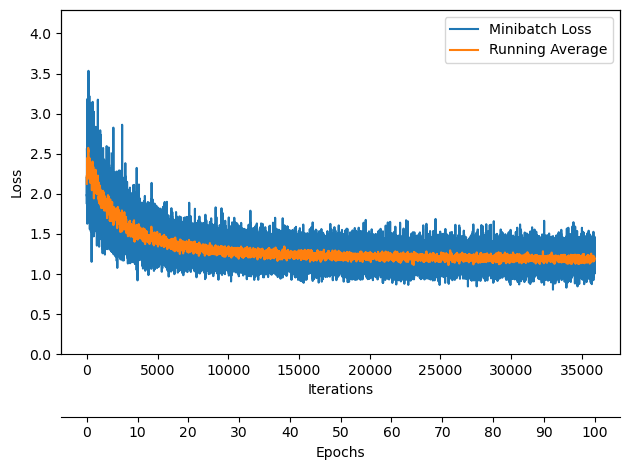

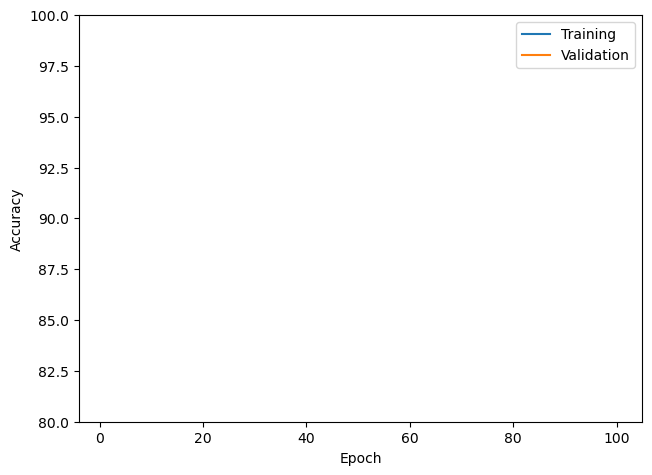

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 57.73
Test Accuracy: 54.39


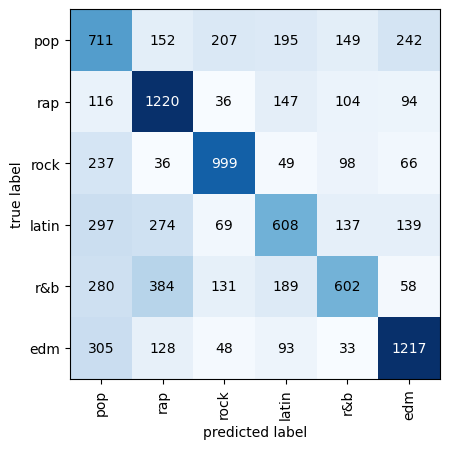

In [13]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()